# LogisticRegression

In [103]:
import pandas as pd
import numpy as np
import os
import time
import random
import json
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import warnings

warnings.filterwarnings('ignore')

In [104]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [105]:
csv_path = r'F:\dataset\merged csv\dataset_balance.csv'
df = pd.read_csv(csv_path)

In [106]:
dict_2classes = {
    'DDoS-SlowLoris': 'Attack', 
    'BenignTraffic': 'Benign'
}


In [107]:
df['label'] = df['label'].map(dict_2classes)
df = df.dropna(subset=['label'])
df['label'] = df['label'].map({'Benign': 0, 'Attack': 1})

In [108]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight'
]


In [109]:
X = df[X_columns].astype('float32')  
y = df['label'].astype('int32')

In [110]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype('float32')

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED, stratify=y, shuffle=True
)

In [112]:
model = LogisticRegression(
    solver='liblinear',        
    penalty='l2',
    max_iter=1000,
    random_state=SEED,
    n_jobs=1                   
)

start_train_time = time.time()
model.fit(X_train, y_train)
end_train_time = time.time()
training_duration = end_train_time - start_train_time

In [113]:
start_pred_time = time.time()
y_pred = model.predict(X_test)
end_pred_time = time.time()

prediction_duration = end_pred_time - start_pred_time

In [114]:
print("Calculating per-case prediction time...")
per_case_times = []
for i in tqdm(range(len(X_test))):
    x_single = X_test[i].reshape(1, -1)
    start_case = time.time()
    _ = model.predict(x_single)
    end_case = time.time()
    elapsed_ms = (end_case - start_case) * 1000  # ms
    per_case_times.append(elapsed_ms)

Calculating per-case prediction time...


100%|██████████| 9371/9371 [00:00<00:00, 15878.75it/s]


In [115]:
per_case_df = pd.DataFrame({'CaseIndex': range(len(per_case_times)), 'PredictionTime_ms': per_case_times})
per_case_df.to_csv('per_case_prediction_time.csv', index=False)
print("Per-case prediction time saved to per_case_prediction_time.csv.")

Per-case prediction time saved to per_case_prediction_time.csv.


Saved comparison data to flow_vs_prediction_time.csv.

📊 avg Prediction Time: 0.0598 ms
📊 avg Flow Duration: 34.37 ms


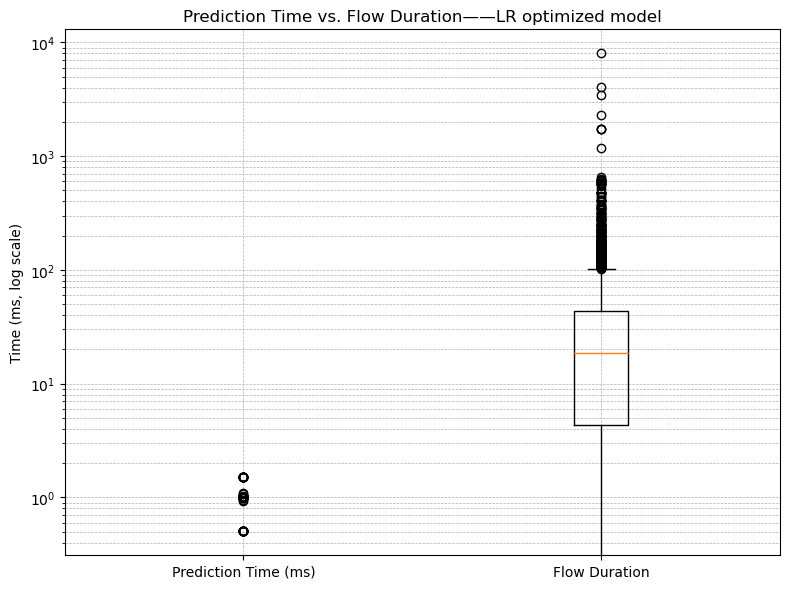

In [116]:
# 还原原始 flow_duration 值（在 test set 中）
original_flow_duration = df['flow_duration'].iloc[y_test.index].reset_index(drop=True)

# 合并 flow_duration 与每个预测样本的预测时间
comparison_df = pd.DataFrame({
    'PredictionTime_ms': per_case_times,
    'FlowDuration': original_flow_duration
})

# 保存数据
comparison_df.to_csv("flow_vs_prediction_time.csv", index=False)
print("Saved comparison data to flow_vs_prediction_time.csv.")

# 平均值比较
avg_pred_time = np.mean(comparison_df['PredictionTime_ms'])
avg_flow_duration = np.mean(comparison_df['FlowDuration'])

print(f"\n📊 avg Prediction Time: {avg_pred_time:.4f} ms")
print(f"📊 avg Flow Duration: {avg_flow_duration:.2f} ms")

# 绘图对比
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot(
    [comparison_df['PredictionTime_ms'], comparison_df['FlowDuration']],
    labels=['Prediction Time (ms)', 'Flow Duration']
)
plt.yscale('log')  # 设置对数坐标轴
plt.title('Prediction Time vs. Flow Duration——LR optimized model')
plt.ylabel('Time (ms, log scale)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("boxplot_logscale_prediction_vs_flowduration.png")
plt.show()

In [117]:
average_case_time_ms = np.mean(per_case_times)
print(f"Average Prediction Time per Case: {average_case_time_ms:.4f} ms")

Average Prediction Time per Case: 0.0598 ms


In [118]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n##### Logistic Regression (2-class) #####")
print("Accuracy:", acc)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print(f"Training Time: {training_duration:.4f} seconds")
print(f"Prediction Time: {prediction_duration:.4f} seconds")


##### Logistic Regression (2-class) #####
Accuracy: 0.8317148650090705
Recall: 0.831711002732543
Precision: 0.8334617066531127
F1 Score: 0.8314930434297061
Training Time: 0.4460 seconds
Prediction Time: 0.0020 seconds


In [119]:
result = {
    "Model": "LR",  
    "Accuracy": float(acc),
    "Precision": float(precision),
    "Recall": float(recall),
    "F1": float(f1),
    "Train Time (s)": float(training_duration),
    "Predict Time (s)": float(prediction_duration),
    "Avg Case Predict Time (ms)": float(average_case_time_ms)
}
with open("result_LR.json", "w") as f: 
    json.dump(result, f, indent=4)

print("Model evaluation results have been saved to result_LR.json.")

Model evaluation results have been saved to result_LR.json.


In [120]:
# 导出模型参数
params = {
    "weight": model.coef_[0].tolist(),   # shape: [n_features]
    "bias": model.intercept_[0].item()   # scalar
}

with open("lr_model_params.json", "w") as f:
    json.dump(params, f)

print("Saved model parameters to lr_model_params.json")

Saved model parameters to lr_model_params.json


In [121]:
with open("scaler_params.json", "w") as f:
    json.dump({
        "means": scaler.mean_.tolist(),
        "scales": scaler.scale_.tolist()
    }, f, indent=2)

In [122]:
print("weights =", model.coef_.tolist()[0])
print("bias =", model.intercept_[0])

weights = [0.18489009407964774, -4.103969722812338, -0.048399358015520255, -0.7833095844230045, 0.07016704233627463, 0.07016704233627463, 0.0, 0.2340959052678577, 0.0, 0.3094395926932752, 0.1665835536408595, 0.4290878153024828, 0.0, 0.0, -0.19499850931098037, 1.005983091442633, 0.03650232884298398, -1.2568998929817816, 3.527481731479834, 0.7780174741985453, -0.04250008485010042, -0.21725042626553032, 0.0, 0.0, 0.0, 0.0, 0.3818091360620639, 0.1863020532211457, 0.0, -0.014389091223625269, 0.0, 0.04155015398598527, 0.04155015398598527, 0.1714750994407288, 0.06897623524643377, -0.5059366944224091, 0.46719686175370184, -0.40845147586188135, -0.6743783699475249, 0.1542731534285026, -0.16866109747210878, -0.613477003888617, 0.5552434561589492, 0.17288747402734814, -0.17858594704963898, 0.12516706441628567]
bias = 0.1292430988426725
